In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import folium
import json
from folium import plugins
import geopy.distance
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
def get_store_lat_lngs(zcode):
    request = f'https://www.starbucks.com/store-locator?place={zcode}'
    response = requests.get(request)
    lat_lngs = re.findall(r'"coordinates":\{"latitude":(.*?)\,"longitude":(.*?)\}', response.text)
    lat_lngs = [(float(item[0]), float(item[1])) for item in lat_lngs]
    return lat_lngs

# Get all Starbucks Locations

In [3]:
la_zips = pd.read_csv('Zip_Codes_(LA_County).csv')

In [4]:
starbucks_locs = []

In [5]:
for i,zcode in enumerate(la_zips.ZIPCODE.values):
    print(f'{i} / {len(la_zips)}')
    starbucks_locs += get_store_lat_lngs(zcode)

0 / 311
1 / 311
2 / 311
3 / 311
4 / 311
5 / 311
6 / 311
7 / 311
8 / 311
9 / 311
10 / 311
11 / 311
12 / 311
13 / 311
14 / 311
15 / 311
16 / 311
17 / 311
18 / 311
19 / 311
20 / 311
21 / 311
22 / 311
23 / 311
24 / 311
25 / 311
26 / 311
27 / 311
28 / 311
29 / 311
30 / 311
31 / 311
32 / 311
33 / 311
34 / 311
35 / 311
36 / 311
37 / 311
38 / 311
39 / 311
40 / 311
41 / 311
42 / 311
43 / 311
44 / 311
45 / 311
46 / 311
47 / 311
48 / 311
49 / 311
50 / 311
51 / 311
52 / 311
53 / 311
54 / 311
55 / 311
56 / 311
57 / 311
58 / 311
59 / 311
60 / 311
61 / 311
62 / 311
63 / 311
64 / 311
65 / 311
66 / 311
67 / 311
68 / 311
69 / 311
70 / 311
71 / 311
72 / 311
73 / 311
74 / 311
75 / 311
76 / 311
77 / 311
78 / 311
79 / 311
80 / 311
81 / 311
82 / 311
83 / 311
84 / 311
85 / 311
86 / 311
87 / 311
88 / 311
89 / 311
90 / 311
91 / 311
92 / 311
93 / 311
94 / 311
95 / 311
96 / 311
97 / 311
98 / 311
99 / 311
100 / 311
101 / 311
102 / 311
103 / 311
104 / 311
105 / 311
106 / 311
107 / 311
108 / 311
109 / 311
110 / 311


In [6]:
starbucks_locs = set(starbucks_locs)

In [7]:
starbucks_locs = list(starbucks_locs)

# Distance to Closest Starbucks

In [8]:
dist_matrix = np.empty((len(starbucks_locs), len(starbucks_locs)))
for i1,s1 in enumerate(starbucks_locs):
    for i2,s2 in enumerate(starbucks_locs):
        if i1 <= i2:
            d = geopy.distance.geodesic(s1, s2).mi
            dist_matrix[i1,i2] = d
            dist_matrix[i2,i1] = d

In [9]:
np.fill_diagonal(dist_matrix, np.inf)

In [11]:
closest_locs = np.argmin(dist_matrix, axis=0)
closest_dists = dist_matrix[np.arange(len(starbucks_locs)), closest_locs]

In [15]:
#map of LA county
with open('laMap.geojson') as f:
    laArea = json.load(f)
    
la_lng_lats = laArea['features'][0]['geometry']['coordinates'][0][0]
polygon = Polygon(la_lng_lats)

#initialize the map around LA County
laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)

#add the shape of LA County to the map
folium.GeoJson(laArea).add_to(laMap)

#for each row in the Starbucks dataset, plot the corresponding latitude and longitude on the map
for lat,lng in starbucks_locs:
    if polygon.contains(Point(lng,lat)):
        folium.CircleMarker((lat, lng), radius=4, weight=2, color='red', fill_color='red', fill_opacity=.5).add_to(laMap)
   
closest_dists_lim = []
closest_locs = np.argmin(dist_matrix, axis=0)
for i1,s1 in enumerate(starbucks_locs):
    if polygon.contains(Point(s1[1],s1[0])):
        s2 = starbucks_locs[closest_locs[i1]]
        d = round(closest_dists[i1], 2)
        folium.PolyLine([s1,s2], color='black', popup=f'{d} miles', fontsize=20).add_to(laMap)
        closest_dists_lim.append(d)
closest_dists_lim = np.array(closest_dists_lim)
    
#save the map as an html    
laMap.save('laSbuxMap.html')

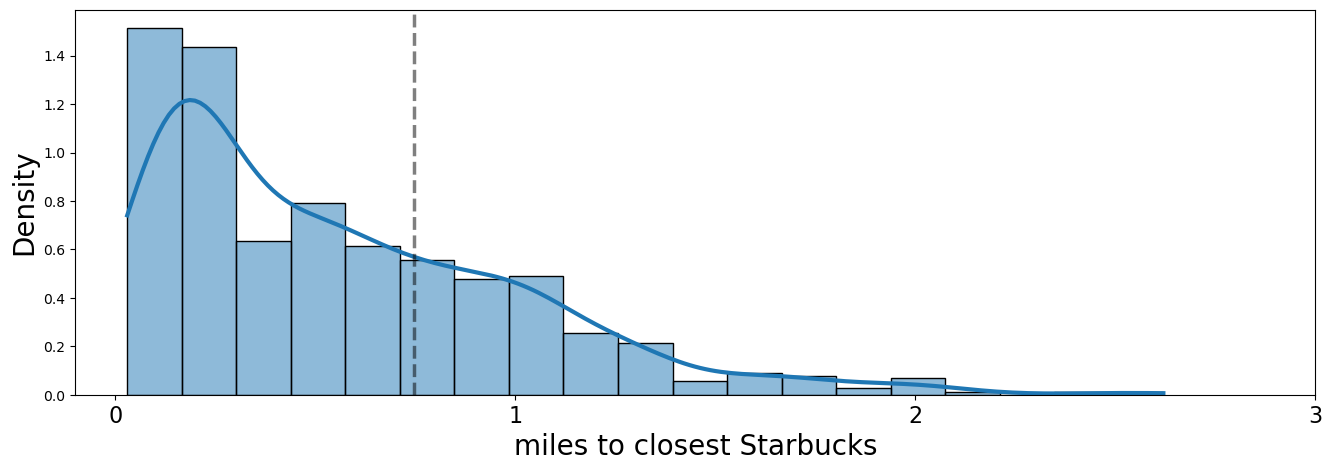

In [16]:
plt.figure(figsize=(16,5))
sns.histplot(closest_dists_lim, kde=True, line_kws={'linewidth': 3}, stat='density')
plt.xlabel('miles to closest Starbucks', fontsize=20)
plt.xticks(np.arange(0, 3.1), fontsize=16)
plt.ylabel('Density', fontsize=20)
plt.axvline(np.mean(closest_dists), color='k', linestyle='--', linewidth=2.5, alpha=0.5)